# Project Title

Measuring Public Perception of Apple and Google on Twitter Using Machine Learning

# Phase 1: Business Understanding

## Objective
Build a Natural Language Processing (NLP) model to classify tweets mentioning **Apple** or **Google** into **positive**, **negative**, or **neutral** sentiments. This will help understand public perception, monitor brand reputation, and inform marketing and product strategies.

## Key Questions
- How do people feel about Apple vs Google products on social media?  
- Which words or phrases are most influential in expressing sentiment?  
- Do specific events or product launches trigger changes in sentiment?  

## Business Impact
- **Marketing Strategy:** Adjust campaigns based on trends in sentiment.  
- **Customer Support:** Prioritize responses when negative sentiment spikes.  
- **Product Development:** Identify common issues or requests from user feedback.  
- **Crisis Management:** Detect negative trends early to mitigate PR risks.


# Phase 2: Data Understanding

## Dataset Overview
- **Source:** CrowdFlower via data.world  
- **Total tweets:** ~9,000 (Apple and Google mentions)  
- **Labels:** Positive, Negative, Neutral (human-annotated)  

## Key Columns

| Column | Description | Example |
|--------|-------------|---------|
| `tweet_text` | The content of the tweet | "I love my new iPhone!" |
| `emotion_in_tweet_is_directed_at` | Brand or product mentioned | "iPhone" |
| `is_there_an_emotion_directed_at_a_brand_or_product` | Sentiment label | Positive, Negative, Neutral |


## Dataset Suitability
- Real user opinions, unstructured text  
- Labeled for sentiment → suitable for supervised ML  
- Allows tracking trends over time and across products


##  Importing Required Libraries

In [3]:
# Core & utilities
import time
import re
import joblib
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

# NLP (Natural Language Processing)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn: preprocessing, feature extraction, and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn: metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from xgboost import XGBClassifier

In [4]:
# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...


True

 Loading the data

In [6]:
df = pd.read_csv("tweets.csv", encoding="latin-1")

 Data Quality Assessment

In [8]:
#Display the first 5 rows of the dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
#Display the names of all available columns in the DataFrame
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [10]:
#Display the number of rows and columns in the dataset
df.shape

(9093, 3)

In [11]:
# getting information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [12]:
df['tweet_text'].head()

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet_text, dtype: object

# Phase 3: Data Cleaning

In this step, we prepare the dataset by removing unnecessary information, handling missing values, and making the data ready for analysis and modeling. The main steps are:


# 1 Dropping unwanted columns

Remove irrelevant columns such as emotion_in_tweet_is_directed_at that do not add value to the **analysis**

# Display all column names
This helps as understand:

Which columns contain tweet text

Which column is the sentiment label

Which columns are unnecessary

In [13]:
print(df.columns)


Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [14]:
# DROP UNWANTED COLUMNS
# It does not improve sentiment analysis

df.columns = df.columns.str.strip().str.lower()      # normalize column names

df = df.drop(columns=['emotion_in_tweet_is_directed_at'],
             errors='ignore')

# 2 Handling missing values

Drop rows with missing values in the sentiment column.
Fill missing values in other columns with placeholders if necessary.

In [15]:
# Checking Missing Values in each column
df.isnull().sum()


tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [16]:
# HANDLE MISSING VALUES
# To avoid Breaking the model training
# Create wrong predictions

# Drop missing sentiment rows
df = df.dropna(subset=['is_there_an_emotion_directed_at_a_brand_or_product'])


# Fill other missing values
# We replace them with “Unknown” to avoid errors:
# Tf-IDF Does not allow NaN
df.fillna("Unknown", inplace=True)

# 3 Renaming columns and sentiment categories

Rename long column names to shorter, more intuitive ones (e.g., is_there_an_emotion_directed_at_a_brand_or_product → sentiment).
Standardize sentiment labels (No emotion toward brand or product → neutral, etc.).

The sentiment column name is too long and hard to type

Code becomes messy

Models prefer simple, readable column names

In [17]:
# RENAME COLUMNS + STANDARDIZE SENTIMENT LABELS

df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'},
          inplace=True)

# Inspect Sentiment Values
print(df['sentiment'].unique())



['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]


# We notice

Some labels are UPPERCASE, some lowercase

Some have spaces like "negative Emotion "

“I can’t tell” is NOT useful for model training

“No emotion…” is too long

In [18]:
#Why standardize sentiment
# For Consistency,Easier coding,Better accuracy
# First convert to lowercase
df['sentiment'] = df['sentiment'].astype(str).str.lower().str.strip()
# Replace long labels with cleaner ones:
df['sentiment'] = df['sentiment'].replace({
    'no emotion toward brand or product': 'neutral',
    'positive emotion': 'positive',
    'negative emotion': 'negative',
    "i can't tell": 'unknown'
})

# 4 Removing unwanted categories

Drop rows where the sentiment is I can't tell since it does not provide useful information for the model.

In [19]:
# Chech which cell is empty
# df.isnull().sum()
# If a cell is empty, it marks it as True(missing)
# If it is not empty, it marks it as False(not missing)

# STEP 4: REMOVE UNWANTED CATEGORIES
df = df[df['sentiment'] != 'unknown']

# 5 Cleaning text data

Convert text to lowercase.
Remove URLs, numbers, punctuation, and extra spaces.
Ensure the text is consistent and ready for vectorization.

In [20]:
#Raw text from tweets is messy
#URLs like http://...
#Mentions like @username
#Hashtags like #happy
#Numbers, punctuation, extra spaces
print(df['tweet_text'].head())


0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet_text, dtype: object


In [21]:

# CLEAN TEXT DATA
# Define a cleaning function

def clean_text(text):
    text = str(text).lower()

    text = re.sub(r'http\S+|www\S+', '', text)     # remove URLs
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)      # remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)      # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)            # remove punctuation + numbers
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra spaces

    return text
#Apply cleaning function
df['text_clean'] = df['tweet_text'].apply(clean_text)

# Remove stopwords
#Stopwords like “the”, “is”, “at” don’t help the model.
stop_words = set(stopwords.words('english'))
df['text_clean'] = df['text_clean'].apply(
    lambda x: ' '.join([w for w in x.split() if w not in stop_words])
)

# Tokenize
# Split each tweet into words (tokens) for further processing:
df['tokens'] = df['text_clean'].apply(word_tokenize)

# Lemmatize
#Convert words to their root form, e.g., “running” → “run”
lemmatizer = WordNetLemmatizer()
df['tokens_lemmatized'] = df['tokens'].apply(
    lambda t: [lemmatizer.lemmatize(w) for w in t]
)

# Rebuild final text
# After lemmatization, join tokens back into a clean string for vectorization:
df['text_final'] = df['tokens_lemmatized'].apply(lambda t: " ".join(t))


# 6 Text vectorization

Transform the cleaned text into numerical format using techniques like:
Bag of Words (CountVectorizer) Counts how many times each word appears in a document

TF-IDF (TfidfVectorizer)  Counts words but reduces weight of common words across all documents


 Because Machine learning models cannot work directly with text.
Vectorization converts cleaned text into numbers that a model can understand.

In [22]:
# TEXT VECTORIZATION

# Bag of Words
#Creates a vocabulary of all words in the dataset
#Counts how many times each word appears in each tweet
#Returns a sparse matrix (numerical format)
bow = CountVectorizer()
X_bow = bow.fit_transform(df['text_final'])

# TF-IDF (recommended)
#Words that appear in many tweets (like "love", "product") get lower weight
#Words that are rare but important get higher weight
#Makes features more meaningful for classification
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['text_final'])


# Features and labels
# X → what the model uses to learn patterns
# y → what the model tries to predict (positive/neutral/negative)

X = X_tfidf # Features (numerical representation of text)
y = df['sentiment']#Target labels



In [24]:
# Chicking the final output
print(df[['tweet_text', 'sentiment', 'text_final']].head())
print("\nSentiment distribution:\n", y.value_counts())

                                          tweet_text sentiment  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...  negative   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  positive   
2  @swonderlin Can not wait for #iPad 2 also. The...  positive   
3  @sxsw I hope this year's festival isn't as cra...  negative   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...  positive   

                                          text_final  
0  g iphone hr tweeting dead need upgrade plugin ...  
1  know awesome ipadiphone app youll likely appre...  
2                                     wait also sale  
3     hope year festival isnt crashy year iphone app  
4  great stuff fri marissa mayer google tim oreil...  

Sentiment distribution:
 neutral     5389
positive    2978
negative     570
Name: sentiment, dtype: int64


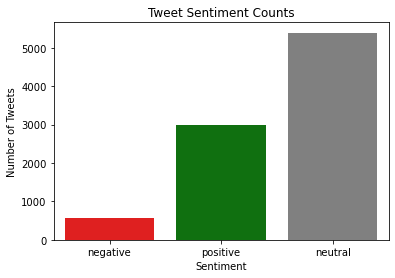

In [25]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette={'neutral':'gray', 'positive':'green', 'negative':'red'})
plt.title('Tweet Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


## Interpretation of Tweet Sentiment Counts (Bar Chart)

- **Neutral (5,500 tweets):**  
  The majority of tweets are neutral, indicating that most users are either sharing information or not expressing strong opinions about Apple or Google products.

- **Positive (3,000 tweets):**  
  A significant portion of tweets show favorable sentiment, reflecting user satisfaction or approval.

- **Negative (600 tweets):**  
  Only a small fraction of tweets are negative, suggesting limited dissatisfaction expressed on Twitter.


 Indeed The bar chart confirms that the majority of users are neutral or positive, with negative reactions being minimal. This insight can guide marketing and customer engagement strategies to maintain positive sentiment while monitoring negative feedback for potential improvements.